In [2]:
import sys
sys.path.append('../..')

import eeg_decoder
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sista

import scipy.io as io

%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns

In [3]:
experiment_name = 'data'
data_dir = f'./data/'
exp = eeg_decoder.Experiment(experiment_name,data_dir,dev=False,trim_timepoints=[-200,1500])
eyefiles = sorted(list(exp.data_dir.glob('*eyetracking*.mat')))

In [4]:
time_window = 25 
time_step = 25
trial_bin_size = 15 
n_splits = 1000
group_dict = OrderedDict([('SS1_col',[11]),('SS2_col',[12]), ('SS1_mot',[21]),('SS2_mot',[22])])

In [5]:
def str_to_arr(s, sep=' '):
    pieces = s.replace('[', '').replace(']', '').replace(',', '').split(sep)
    return np.array([float(i) for i in pieces])

def get_target_coherences(row):
    return int(np.sum(str_to_arr(row['Coherences'])[:row['SetSize']]))

def get_distractor_coherences(row):
    return int(np.sum(str_to_arr(row['Coherences'])[row['SetSize']:]))

def add_condition_info(beh):
    beh['cond_labels'] = beh['BlockFeature']*100+100  # color = 100, motion = 200
    beh['cond_labels'] += beh['SetSize']*10  # ss1=10, ss2=20
    beh['cond_labels'] += beh.apply(get_target_coherences, axis=1)*1  # coherence = 0, 1, 2

    # add info about the distractor coherence, shown below to be uninformative generally
    beh['full_cond_labels'] =  beh['cond_labels'].values*10 # shift by 1 decimal place
    beh['full_cond_labels'] += beh.apply(get_distractor_coherences, axis=1)  # distractor coherence = 0, 1, 2

    return beh

In [5]:
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)
clfr_eyes = eeg_decoder.Classification(wrangl,exp.nsub)

bad_eye_subs = [14]
for isub in range(exp.nsub):
    

    if isub in bad_eye_subs:
        continue
    print(isub)

    # get the "original" xdata (og), which will be copied and modified for each permutation
    xdata_eeg,_ = exp.load_eeg(isub)

    # get the original ydata labels for each trial, which will be copied and modified for each permutation
    beh = pd.DataFrame(exp.load_behavior(isub))
    beh = add_condition_info(beh)

    art_idx = exp.load_artifact_idx(isub)

    pupil_data = exp.load_pupil_data(isub)

    pupil_data = pupil_data[..., art_idx]

    assert pupil_data.shape[-1] == xdata_eeg.shape[0]  # make sure same number of trials


    pupil_data -= pupil_data[:, exp.info['times'] < 0, :].mean(1)[:, np.newaxis, :]  # subtract baseline

    pupil_data = pupil_data.mean(0)  # average across pupils
    pupil_data = pupil_data[exp.info['times'] > 500].mean(0)  # average across delay period

    

    beh = beh.assign(pupil=pupil_data)

    # average across the 10 conditions
    # z-score for each eye seprarately

    cond_means = beh.groupby('cond_labels').mean().loc[:, 'pupil']

    cond_means.to_csv(f'output/pupil_data/{isub}_pupil_means.csv')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
15


In [17]:
# loading just to get the same time bins for pupil and RSA
interp_coh = eeg_decoder.Interpreter()
interp_coh.load_results('coherence_axis')

In [69]:
wrangl = eeg_decoder.Wrangler(exp.info['times'],time_window,time_step,trial_bin_size,n_splits,group_dict)
clfr = eeg_decoder.Classification(wrangl,exp.nsub)
clfr_eyes = eeg_decoder.Classification(wrangl,exp.nsub)

bad_eye_subs = [14]

all_pupil = pd.DataFrame()
all_pupil_z = pd.DataFrame()

for isub in range(exp.nsub):
    

    if isub in bad_eye_subs:
        continue
    print(isub)

    # get the "original" xdata (og), which will be copied and modified for each permutation
    xdata_eeg,_ = exp.load_eeg(isub)

    # get the original ydata labels for each trial, which will be copied and modified for each permutation
    beh = pd.DataFrame(exp.load_behavior(isub))
    beh = add_condition_info(beh)

    art_idx = exp.load_artifact_idx(isub)

    pupil_data = exp.load_pupil_data(isub)

    pupil_data = pupil_data[..., art_idx]
    assert pupil_data.shape[-1] == xdata_eeg.shape[0]  # make sure same number of trials

    # drop SS0 trials
    keep_conds = ~beh['cond_labels'].isin([100, 200])  # SS0 conditions which probably had big surprise for some people
    beh = beh[keep_conds]
    pupil_data = pupil_data[:, :, keep_conds]
    

    pupil_data -= pupil_data[:, exp.info['times'] < 0, :].mean(1)[:, np.newaxis, :]  # subtract baseline

    pupil_data = pupil_data.mean(0)  # average across pupils

    pupil_binned = np.full((pupil_data.shape[1], len(interp_coh.t)), np.nan)  # reorder the data to match the RSA
    for i, bin_start in enumerate(interp_coh.t):
        if i < len(interp_coh.t)-1:
            window_idx = (exp.info['times'] >= bin_start) & (exp.info['times'] < interp_coh.t[i+1])
        else:
            window_idx = (exp.info['times'] >= bin_start)
        pupil_binned[:, i] = pupil_data[window_idx, :].mean(0)  # note the flipping axes!

    
    pupil_binned = (pupil_binned - pupil_binned.mean()) / pupil_binned.std()  # z-score the data

    pupil_df = pd.DataFrame(pupil_binned)
    pupil_df['Cond'] = beh['cond_labels'].values
    pupil_df = pupil_df.groupby('Cond').mean()
    pupil_df = pupil_df.reset_index().assign(sub=isub).melt(id_vars=['sub', 'Cond'], var_name='Time', value_name='Pupil')
    all_pupil = pd.concat([all_pupil, pupil_df])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
15


In [74]:
all_pupil.to_csv('output/pupil_by_time.csv')

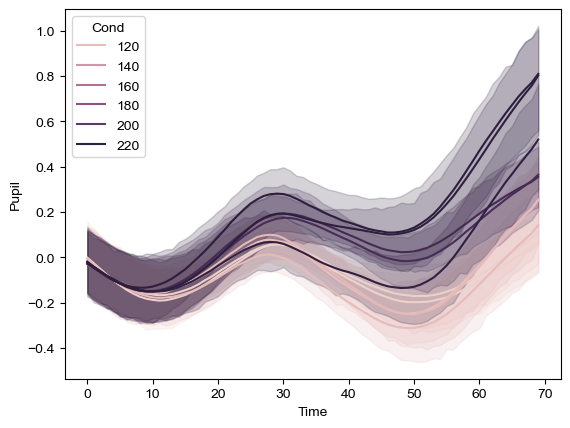

In [75]:
_ = sns.lineplot(data=all_pupil, x='Time', y='Pupil', hue='Cond')